In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
train_data = datasets.CIFAR10(
    root = 'data',
    download = True,
    train = True,
    transform = ToTensor()
)

test_data = datasets.CIFAR10(
    root = 'data',
    download = True,
    train = False,
    transform = ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(train_data), len(test_data)

(50000, 10000)

In [4]:
text_label = train_data.classes

Numeric Label : 6
Textual Label : frog


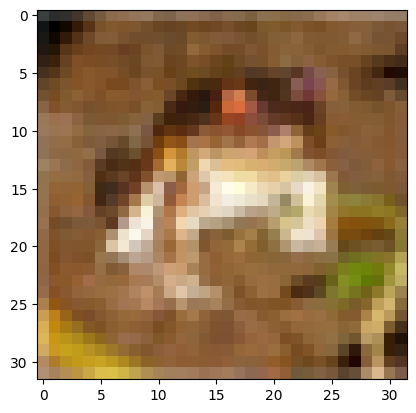

In [5]:
img, label = train_data[0]
plt.imshow(img.permute(1, 2, 0), cmap = 'gray')
print(f"Numeric Label : {label}")
print(f"Textual Label : {text_label[label]}")

Numeric Label : 5
Textual Label : dog


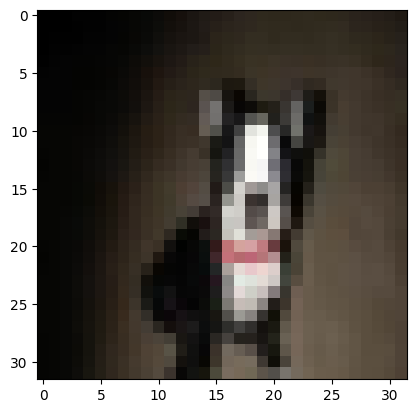

In [6]:
img, label = train_data[198]
plt.imshow(img.permute(1, 2, 0), cmap = 'gray')
print(f"Numeric Label : {label}")
print(f"Textual Label : {text_label[label]}")

Numeric Label : 9
Textual Label : truck


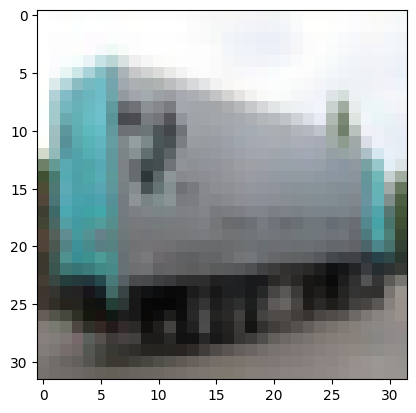

In [7]:
img, label = train_data[45198]
plt.imshow(img.permute(1, 2, 0), cmap = 'gray')
print(f"Numeric Label : {label}")
print(f"Textual Label : {text_label[label]}")

In [8]:
val_size = 5000
train_size = len(train_data) - val_size
train_size, val_size

(45000, 5000)

In [9]:
train_ds, val_ds = random_split(train_data, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [10]:
batch_size = 128
train_dataloader = DataLoader(train_ds, batch_size, shuffle = True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size * 2, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size * 2, num_workers=2, pin_memory=True)

images.shape : torch.Size([128, 3, 32, 32])
labels.shape: torch.Size([128])


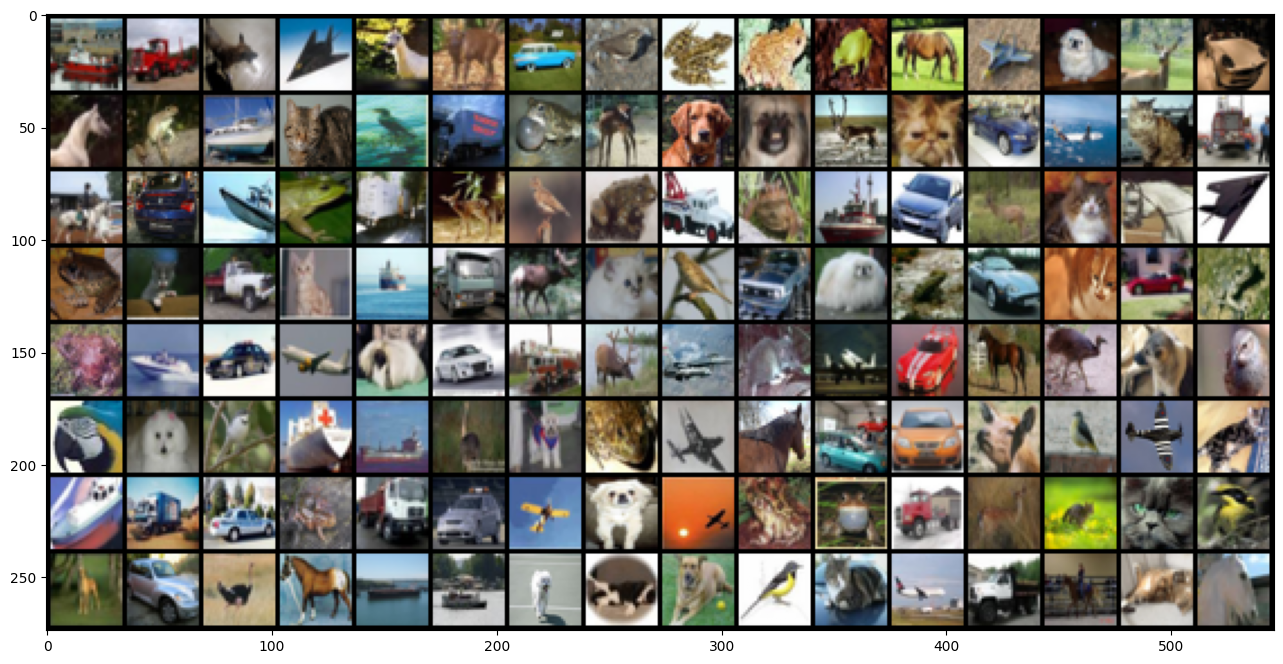

In [11]:
for images, labels in train_dataloader:
    print(f"images.shape : {images.shape}")
    print(f"labels.shape: {labels.shape}")
    plt.figure(figsize=(16, 8))
    plt.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
    break

In [12]:
def accuracy(outputs, labels):
    probs, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(labels == preds).item() / len(labels))

In [13]:
class BaseModel(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss' : loss, 'val_acc' : acc}

    def validation_epoch_end(self, val_outputs):
        batch_losses = [x['val_loss'] for x in val_outputs]
        epoch_losses = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in val_outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss' : epoch_losses.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, results):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, results['val_loss'], results['val_acc']))

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [16]:
class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)

In [17]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

In [18]:
def evaluate(model, dataloader):
    outputs = [model.validation_step(batch) for batch in dataloader]
    return model.validation_epoch_end(outputs)

In [19]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = []
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
class CIFAR10Model(BaseModel):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)

    def forward(self, batch):
        out = self.flatten(batch)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        return out

In [21]:
model = CIFAR10Model()

In [22]:
to_device(model, device)

CIFAR10Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [23]:
for batch in train_dataloader:
    loss = model.training_step(batch)
    print(loss)
    break

tensor(2.2934, device='cuda:0', grad_fn=<NllLossBackward0>)


In [24]:
history = [evaluate(model, val_dataloader)]
history

[{'val_loss': 2.307100296020508, 'val_acc': 0.09412913024425507}]

In [25]:
history = fit(50, 1e-3, model, train_dataloader, val_dataloader, opt_func=torch.optim.Adam)

Epoch [0], val_loss: 1.8371, val_acc: 0.3332
Epoch [1], val_loss: 1.7330, val_acc: 0.3677
Epoch [2], val_loss: 1.6527, val_acc: 0.4043
Epoch [3], val_loss: 1.6011, val_acc: 0.4191
Epoch [4], val_loss: 1.5599, val_acc: 0.4402
Epoch [5], val_loss: 1.5053, val_acc: 0.4605
Epoch [6], val_loss: 1.5634, val_acc: 0.4389
Epoch [7], val_loss: 1.4901, val_acc: 0.4728
Epoch [8], val_loss: 1.4959, val_acc: 0.4607
Epoch [9], val_loss: 1.4750, val_acc: 0.4649
Epoch [10], val_loss: 1.4539, val_acc: 0.4827
Epoch [11], val_loss: 1.4456, val_acc: 0.4853
Epoch [12], val_loss: 1.4723, val_acc: 0.4749
Epoch [13], val_loss: 1.4081, val_acc: 0.4940
Epoch [14], val_loss: 1.4080, val_acc: 0.5008
Epoch [15], val_loss: 1.4020, val_acc: 0.4947
Epoch [16], val_loss: 1.4039, val_acc: 0.4967
Epoch [17], val_loss: 1.4537, val_acc: 0.4783
Epoch [18], val_loss: 1.4290, val_acc: 0.4880
Epoch [19], val_loss: 1.3961, val_acc: 0.5046
Epoch [20], val_loss: 1.3955, val_acc: 0.5061
Epoch [21], val_loss: 1.4556, val_acc: 0.494

In [26]:
def plot_loss(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')

def plot_accuracy(history):
    acc = [x['val_acc'] for x in history]
    plt.plot(acc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')

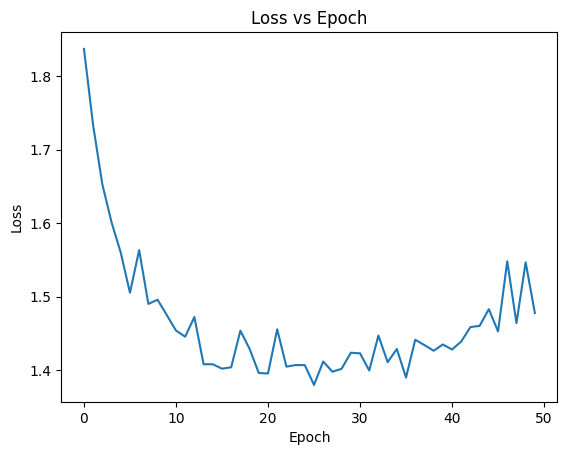

In [27]:
plot_loss(history)

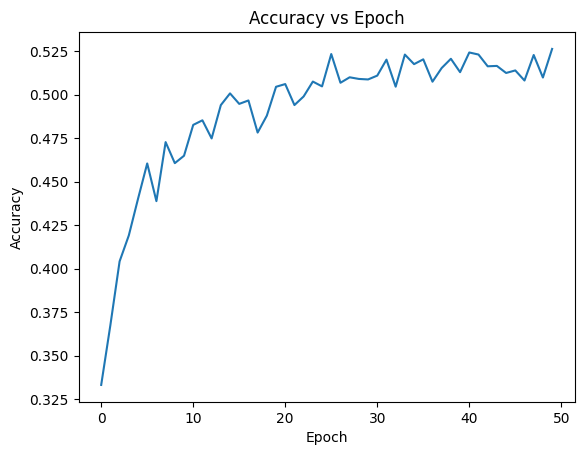

In [28]:
plot_accuracy(history)

In [29]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    prob, pred = torch.max(yb, dim = 1)
    return pred[0].item()

Label: cat , Predicted: cat


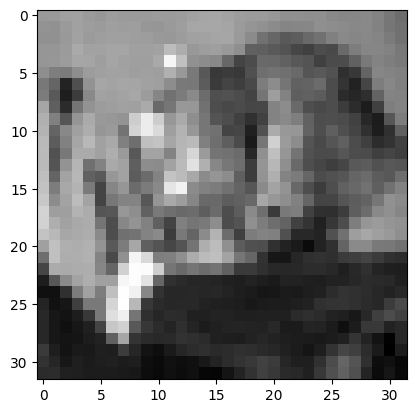

In [30]:
img, label = test_data[0]
plt.imshow(img[0], cmap='gray')
print('Label:', text_label[label], ', Predicted:', text_label[predict_image(img, model)])

In [31]:
evaluate(model, test_dataloader)

{'val_loss': 1.4767264127731323, 'val_acc': 0.523144543170929}

In [33]:
torch.save(model.state_dict(), 'cifar10_trained_parameters.pth')